Attempting to load data from: Synthetic_Data.csv
Data loaded successfully. Shape: (5000, 36)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SettlementValue             4894 non-null   float64
 1   AccidentType                4878 non-null   object 
 2   Injury_Prognosis            4844 non-null   object 
 3   SpecialHealthExpenses       4870 non-null   float64
 4   SpecialReduction            4879 non-null   float64
 5   SpecialOverage              4883 non-null   float64
 6   GeneralRest                 4872 non-null   float64
 7   SpecialAdditionalInjury     4866 non-null   float64
 8   SpecialEarningsLoss         4872 non-null   float64
 9   SpecialUsageLoss            4870 non-null   float64
 10  SpecialMedications          4870 non-null   float64
 11  SpecialAssetDamage          4889 non-null 

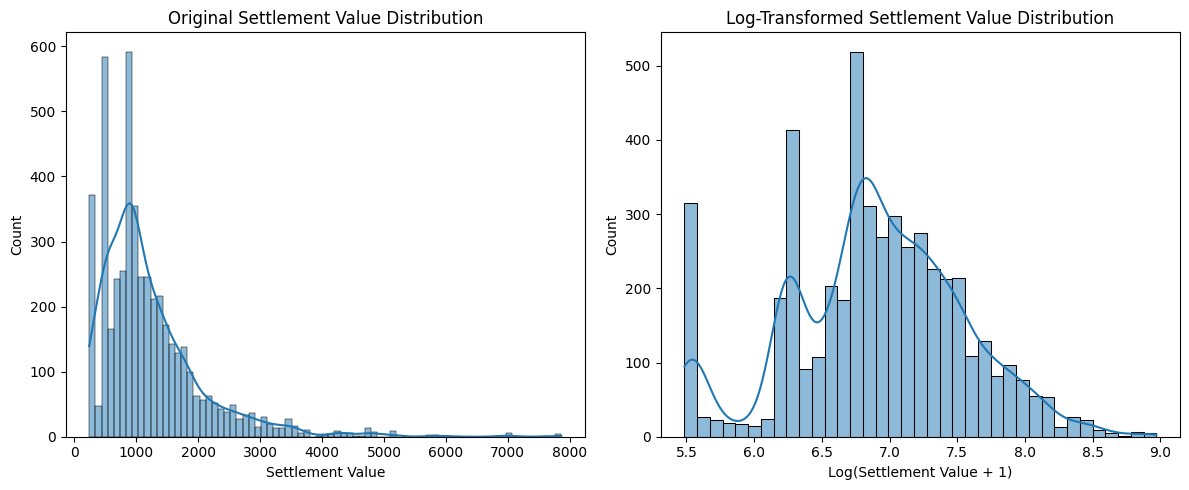

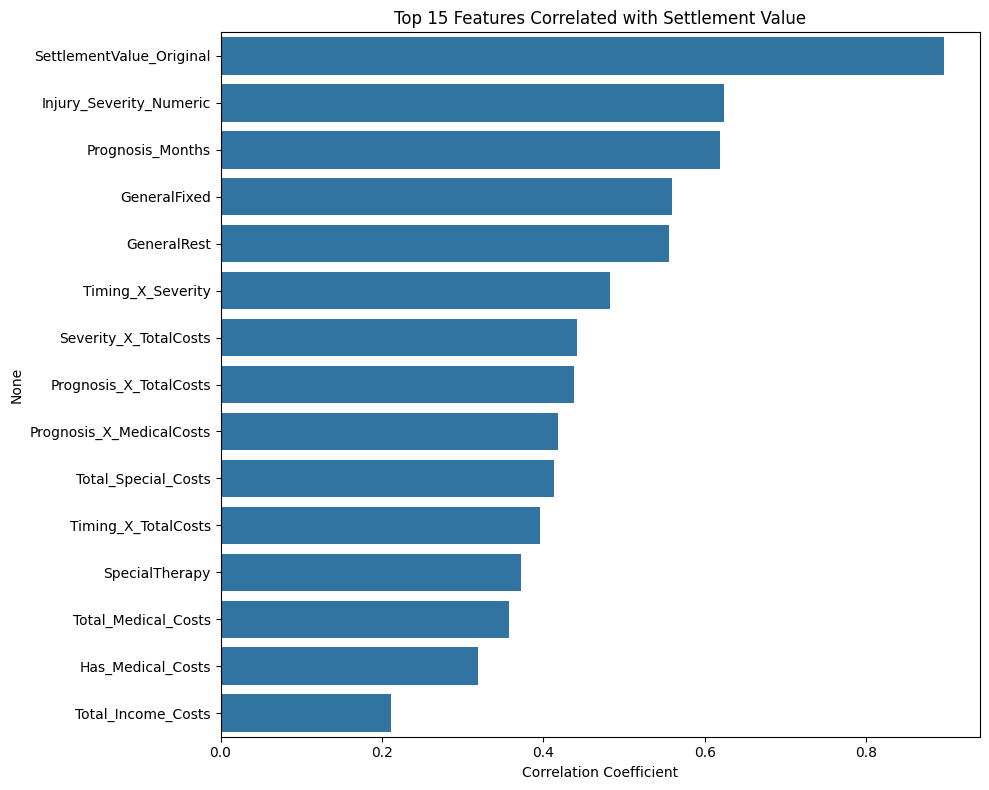


--- Analyzing Processed Data for Categorical Encoding ---
Loaded processed data with shape: (4894, 115)
Found 0 columns with 'onehot' in the name

Data types in processed data:
float64    115
Name: count, dtype: int64


In [7]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold

# Set up basic configuration
CSV_FILE_PATH = "Synthetic_Data.csv"
TARGET_COLUMN = 'SettlementValue'
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Define columns with special handling requirements
# Features with zero variance or that should be dropped
COLS_TO_DROP_MANUALLY = ['SpecialReduction']  # Has zero variance in the data

# Binary columns (Yes/No values)
BINARY_COLS_YES_NO = [
    'Exceptional_Circumstances', 'Minor_Psychological_Injury', 'Whiplash',
    'Police Report Filed', 'Witness Present'
]

# All categorical features in the dataset
CATEGORICAL_COLS = [
    'AccidentType', 'Dominant injury', 'Vehicle Type', 
    'Weather Conditions', 'Accident Description', 'Injury Description', 
    'Gender'
]

# Special cost columns that should be imputed with zeros when missing
SPECIAL_COST_COLS_IMPUTE_ZERO = [
    'SpecialHealthExpenses', 'SpecialOverage', 'SpecialAdditionalInjury',
    'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications',
    'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes',
    'SpecialLoanerVehicle', 'SpecialTripCosts',
    'SpecialJourneyExpenses', 'SpecialTherapy'
]

# Date columns for feature engineering
DATETIME_COLS = ['Accident Date', 'Claim Date']
EXPECTED_DATE_FORMAT = '%d/%m/%Y %H:%M:%S'

# Column for prognosis feature engineering
PROGNOSIS_COL = 'Injury_Prognosis'

# Configure display settings for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


def check_categorical_columns(df, categorical_cols_list):
    """
    Check the status of categorical columns in the DataFrame
    """
    print("\n--- Checking Categorical Columns ---")
    print(f"Defined categorical columns: {categorical_cols_list}")
    
    # Check which categorical columns exist in the DataFrame
    found_cols = [col for col in categorical_cols_list if col in df.columns]
    missing_cols = [col for col in categorical_cols_list if col not in df.columns]
    
    print(f"Found {len(found_cols)}/{len(categorical_cols_list)} categorical columns in the DataFrame")
    if missing_cols:
        print(f"Missing categorical columns: {missing_cols}")
    
    # Check the data types of found columns
    for col in found_cols:
        dtype = df[col].dtype
        unique_values = df[col].nunique()
        sample_values = df[col].dropna().sample(min(3, unique_values)).tolist()
        print(f"  {col}: dtype={dtype}, unique_values={unique_values}, samples={sample_values}")
    
    # Check if categorical columns are actually being recognized as categorical type
    object_cols = df.select_dtypes(include=['object']).columns.tolist()
    category_cols = df.select_dtypes(include=['category']).columns.tolist()
    
    print(f"\nColumns with 'object' dtype: {len(object_cols)}")
    print(f"Columns with 'category' dtype: {len(category_cols)}")
    
    # Check for any potential categorical columns that might be missed
    potential_cats = []
    for col in object_cols:
        if col not in categorical_cols_list and df[col].nunique() < 50:  # Arbitrary threshold
            potential_cats.append((col, df[col].nunique()))
    
    if potential_cats:
        print("\nPotential categorical columns that might be missed:")
        for col, nunique in potential_cats:
            print(f"  {col}: {nunique} unique values")
    
    return found_cols


def load_data(filepath):
    """
    Loads data from a CSV file, performs basic checks, and prints summary information.

    Args:
        filepath (str): The path to the CSV file.

    Returns:
        pd.DataFrame: The loaded DataFrame, or None if an error occurs.
    """
    print(f"Attempting to load data from: {filepath}")
    try:
        df = pd.read_csv(filepath)
        print(f"Data loaded successfully. Shape: {df.shape}")

        if TARGET_COLUMN not in df.columns:
            raise ValueError(f"Target column '{TARGET_COLUMN}' not found in the CSV.")

        print("\nData Info:")
        df.info(memory_usage=False)

        print("\nDescriptive Statistics:")
        print(df.describe())

        print("\nSample Data (first 5 rows):")
        print(df.head())
        
        # Check categorical columns
        categorical_found = check_categorical_columns(df, CATEGORICAL_COLS)

        return df

    except FileNotFoundError:
        print(f"Error: File not found at {filepath}. Please check the path.")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None


def initial_clean(df, target_col, cols_to_drop, binary_cols):
   
    if df is None:
        print("Input DataFrame is None. Skipping initial cleaning.")
        return None

    print("\n--- Starting Initial Cleaning ---")
    df_clean = df.copy()

    # Drop rows with missing target values
    initial_rows = len(df_clean)
    if target_col in df_clean.columns:
        df_clean.dropna(subset=[target_col], inplace=True)
        print(f"Dropped {initial_rows - len(df_clean)} rows with missing target ('{target_col}'). New shape: {df_clean.shape}")
    else:
        print(f"Warning: Target column '{target_col}' not found for NaN check.")

    # Drop specified columns
    cols_present_to_drop = [col for col in cols_to_drop if col in df_clean.columns]
    if cols_present_to_drop:
        df_clean = df_clean.drop(columns=cols_present_to_drop)
        print(f"Dropped manually specified columns: {cols_present_to_drop}")
    else:
        print("No manually specified columns to drop were found or present.")

    # Convert binary columns
    print("Converting binary columns...")
    converted_binary_count = 0
    for col in binary_cols:
        if col in df_clean.columns:
            converted_binary_count += 1
            original_missing = df_clean[col].isnull().sum()
            # Handle cases where values are not exactly 'Yes'/'No'
            df_clean[col] = df_clean[col].apply(lambda x: 1 if str(x).lower() == 'yes' else 0 if str(x).lower() == 'no' else np.nan)
            new_missing = df_clean[col].isnull().sum()
            if new_missing > original_missing:
                print(
                    f"  Warning: Mapping 'Yes'/'No' in '{col}' introduced {new_missing - original_missing} NaNs. Check original values.")
            df_clean[col] = df_clean[col].astype(float)

    print(
        f"Attempted conversion for {len(binary_cols)} defined binary columns. Found and converted {converted_binary_count}.")

    # Convert categorical columns to category type
    print("\nConverting categorical columns...")
    categorical_cols_converted = 0
    for col in CATEGORICAL_COLS:
        if col in df_clean.columns:
            # Check if column is already a category
            if df_clean[col].dtype != 'category':
                # Convert to category type
                df_clean[col] = df_clean[col].astype('category')
                categorical_cols_converted += 1
    
    print(f"Converted {categorical_cols_converted} columns to category data type.")
    
    # Show dtype information for categorical columns
    categorical_cols_present = [col for col in CATEGORICAL_COLS if col in df_clean.columns]
    if categorical_cols_present:
        print("\nCategorical column dtypes:")
        for col in categorical_cols_present:
            print(f"  {col}: {df_clean[col].dtype}")

    print(f"--- Initial Cleaning Complete --- Final shape: {df_clean.shape}")

    return df_clean


def apply_preliminary_imputation(df):
    
    if df is None:
        return None

    df_imputed = df.copy()

    # Count missing values before imputation
    missing_before = df_imputed.isna().sum().sum()
    print(f"Total missing values before preliminary imputation: {missing_before}")

    # 1. Impute special cost columns with 0
    cost_cols = [col for col in df_imputed.columns if
                  col.startswith('Special') and
                  pd.api.types.is_numeric_dtype(df_imputed[col])]

    for col in cost_cols:
        missing = df_imputed[col].isna().sum()
        if missing > 0:
            # Fix the pandas warning by avoiding inplace=True with chained assignment
            df_imputed[col] = df_imputed[col].fillna(0)
            print(f"Preliminary imputation: Filled {missing} missing values in {col} with 0")

    # 2. Impute numeric columns with median
    numeric_cols = [col for col in df_imputed.select_dtypes(include=np.number).columns
                    if col not in cost_cols and col != TARGET_COLUMN] # Exclude the target column
    for col in numeric_cols:
        missing = df_imputed[col].isna().sum()
        if missing > 0:
            median_val = df_imputed[col].median()
            # Fix the pandas warning by avoiding inplace=True with chained assignment
            df_imputed[col] = df_imputed[col].fillna(median_val)
            print(f"Preliminary imputation: Filled {missing} missing values in {col} with median {median_val:.2f}")

    categorical_cols = df_imputed.select_dtypes(include=['object', 'category']).columns

    for col in categorical_cols:
        missing = df_imputed[col].isna().sum()
        if missing > 0:
            # Fix: Check if mode() returns empty series before accessing index [0]
            mode_result = df_imputed[col].mode()
            if not mode_result.empty:
                mode_val = mode_result[0]
                # Fix the pandas warning by avoiding inplace=True with chained assignment
                df_imputed[col] = df_imputed[col].fillna(mode_val)
                print(f"Preliminary imputation: Filled {missing} missing values in {col} with mode '{mode_val}'")
            else:
                # If there is no mode (all values are NaN or equal frequency), use a placeholder
                print(f"Warning: No mode found for '{col}'. Using 'Unknown' as a placeholder.")
                df_imputed[col] = df_imputed[col].fillna('Unknown')

    # Count missing values after imputation
    missing_after = df_imputed.isna().sum().sum()
    print(f"Total missing values after preliminary imputation: {missing_after}")
    print(f"Filled {missing_before - missing_after} missing values in total")

    return df_imputed

# %%
def robust_date_parsing(df, date_cols, expected_format):

    df = df.copy()
    

    primary_format = '%d/%m/%Y %H:%M:%S'
    
    # Try different formats in order of likelihood
    formats_to_try = [
        primary_format,  # Try the expected format first
        expected_format, 
        '%Y-%m-%d %H:%M:%S',
        '%m/%d/%Y %H:%M:%S',
        '%d-%m-%Y %H:%M:%S'
    ]
    
    # Get most common year, month, day for imputation
    now = pd.Timestamp.now()
    default_year = now.year
    default_month = now.month
    default_day = 15  # Middle of month as default
    default_time = '12:00:00'  # Noon as default time
    
    for col in date_cols:
        if col in df.columns:
            # Try parsing with different formats
            success = False
            original_nulls = df[col].isna().sum()
            
            for fmt in formats_to_try:
                try:
                    parsed_dates = pd.to_datetime(df[col], format=fmt, errors='coerce')
                    new_nulls = parsed_dates.isna().sum()
                    
                    # If this format produced fewer nulls than before, use it
                    if new_nulls <= original_nulls + (0.1 * len(df)):  # Allow 10% additional nulls
                        df[col] = parsed_dates
                        print(f"Successfully parsed column '{col}' using format: {fmt}")
                        success = True
                        break
                except Exception as e:
                    continue
            
            if not success:
                # If all formats failed, try the flexible parser as a last resort
                try:
                    df[col] = pd.to_datetime(df[col], errors='coerce')
                    print(f"Parsed '{col}' using flexible date parser")
                    success = True
                except:
                    print(f"Failed to parse column '{col}' as datetime. Column will be dropped or ignored in date feature extraction.")
            
            # Check for missing values after parsing
            missing_dates = df[col].isna()
            if missing_dates.any():
                missing_count = missing_dates.sum()
                print(f"Found {missing_count} missing values in '{col}' after parsing.")
                
                # For Accident Date: impute with median date if available, otherwise use a reasonable default
                if col == 'Accident Date':
                    if df[col].notna().any():
                        # Use median of existing dates
                        median_date = df.loc[df[col].notna(), col].median()
                        # Format as DD/MM/YYYY HH:MM:SS
                        default_date_str = median_date.strftime(primary_format)
                        print(f"Imputing missing Accident Dates with median: {default_date_str}")
                    else:
                        # If all dates are missing, use a default
                        default_date_str = f"{default_day}/{default_month}/{default_year} {default_time}"
                        print(f"All Accident Dates missing. Using default: {default_date_str}")
                    
                    # Convert string to datetime with the same format as the rest of the column
                    default_date = pd.to_datetime(default_date_str, format=primary_format)
                    df.loc[missing_dates, col] = default_date
                
                # For Claim Date: if Accident Date exists, impute with Accident Date + median time difference
                elif col == 'Claim Date':
                    accident_col = 'Accident Date'
                    if accident_col in df.columns and df[accident_col].notna().any() and df[col].notna().any():
                        # Calculate median delay for existing pairs
                        valid_pairs = df.loc[df[accident_col].notna() & df[col].notna()]
                        if len(valid_pairs) > 0:
                            median_delay = (valid_pairs[col] - valid_pairs[accident_col]).median()
                            print(f"Median time from accident to claim: {median_delay}")
                            
                            # Impute Claim Date as Accident Date + median delay
                            # But only for rows where Accident Date exists
                            accident_exists = df[accident_col].notna() & df[col].isna()
                            if accident_exists.any():
                                df.loc[accident_exists, col] = df.loc[accident_exists, accident_col] + median_delay
                                imputed_with_delay = accident_exists.sum()
                                print(f"Imputed {imputed_with_delay} Claim Dates using Accident Date + median delay")
                            
                            # For rows with both dates missing, use median claim date
                            both_missing = df[accident_col].isna() & df[col].isna()
                            if both_missing.any():
                                median_claim_date = df.loc[df[col].notna(), col].median()
                                df.loc[both_missing, col] = median_claim_date
                                print(f"Imputed {both_missing.sum()} Claim Dates using median claim date")
                        else:
                            print("No valid date pairs to calculate median delay")
                    
                    # If we still have missing claim dates, use a default
                    still_missing = df[col].isna()
                    if still_missing.any():
                        if df[col].notna().any():
                            default_claim_date = df.loc[df[col].notna(), col].median()
                        else:
                            # If we have accident dates but no claim dates at all
                            if 'Accident Date' in df.columns and df['Accident Date'].notna().any():
                                # Use median accident date + 30 days as default
                                median_accident = df['Accident Date'].median()
                                default_claim_date = median_accident + pd.Timedelta(days=30)
                            else:
                                # Complete fallback - use default string format
                                default_date_str = f"{default_day}/{default_month}/{default_year} {default_time}"
                                default_claim_date = pd.to_datetime(default_date_str, format=primary_format)
                        
                        df.loc[still_missing, col] = default_claim_date
                        print(f"Imputed remaining {still_missing.sum()} missing Claim Dates")
    
    
    print("Final parsed and imputed date columns:")
    for col in date_cols:
        if col in df.columns and pd.api.types.is_datetime64_any_dtype(df[col]):
            # Just for display, show the format
            print(f"Column '{col}' sample value: {df[col].iloc[0].strftime(primary_format)}")
    
    return df

def extract_date_components(df, date_cols):
    
    df = df.copy()
    
    for col in date_cols:
        if col in df.columns and pd.api.types.is_datetime64_any_dtype(df[col]):
            # Extract basic components
            col_prefix = col.split()[0]  # Use first word of column name as prefix
            df[f'{col_prefix}_Year'] = df[col].dt.year
            df[f'{col_prefix}_Month'] = df[col].dt.month
            df[f'{col_prefix}_Day'] = df[col].dt.day
            df[f'{col_prefix}_DayOfWeek'] = df[col].dt.dayofweek
            df[f'{col_prefix}_Quarter'] = df[col].dt.quarter
            
            # Extract hour if it exists and isn't all the same value
            if df[col].dt.hour.nunique() > 1:
                df[f'{col_prefix}_Hour'] = df[col].dt.hour
                
            # Create cyclical features for periodic time components
            # These help ML algorithms understand the cyclic nature of time
            # For example, December (12) and January (1) are close to each other cyclically
            df[f'{col_prefix}_Month_sin'] = np.sin(2 * np.pi * df[col].dt.month / 12)
            df[f'{col_prefix}_Month_cos'] = np.cos(2 * np.pi * df[col].dt.month / 12)
            df[f'{col_prefix}_DayOfWeek_sin'] = np.sin(2 * np.pi * df[col].dt.dayofweek / 7)
            df[f'{col_prefix}_DayOfWeek_cos'] = np.cos(2 * np.pi * df[col].dt.dayofweek / 7)
            
            if f'{col_prefix}_Hour' in df.columns:
                df[f'{col_prefix}_Hour_sin'] = np.sin(2 * np.pi * df[col].dt.hour / 24)
                df[f'{col_prefix}_Hour_cos'] = np.cos(2 * np.pi * df[col].dt.hour / 24)
    
    return df

def calculate_accident_to_claim_time(df, accident_date_col, claim_date_col):
    """
    Calculates time difference between accident and claim dates.
    Creates both numeric and categorical features with proper data types.
    """
    df = df.copy()
    
    if (accident_date_col in df.columns and claim_date_col in df.columns and
        pd.api.types.is_datetime64_any_dtype(df[accident_date_col]) and
        pd.api.types.is_datetime64_any_dtype(df[claim_date_col])):
        
        # Calculate time difference in days
        df['Accident_To_Claim_Days'] = (df[claim_date_col] - df[accident_date_col]).dt.days
        
        # Make sure the days column is numeric
        df['Accident_To_Claim_Days'] = df['Accident_To_Claim_Days'].astype(float)
        
        # Check for and handle negative time differences (where claim date is before accident date)
        invalid_time_seq = df['Accident_To_Claim_Days'] < 0
        if invalid_time_seq.any():
            num_invalid = invalid_time_seq.sum()
            print(f"Warning: {num_invalid} claims with claim date before accident date detected.")
            
            # Create a flag for these anomalies
            df['Invalid_Date_Sequence'] = invalid_time_seq.astype(int)
            
            # Set invalid time differences to NaN to exclude them from analysis
            df.loc[invalid_time_seq, 'Accident_To_Claim_Days'] = np.nan
            print("These invalid time differences have been set to NaN.")
        
        # For valid times only, create a categorized version
        valid_mask = df['Accident_To_Claim_Days'].notna()
        if valid_mask.any():
            # First create the categories as strings
            timing_categories = pd.cut(
                df.loc[valid_mask, 'Accident_To_Claim_Days'], 
                bins=[0, 7, 30, 90, 180, 365, float('inf')],
                labels=['Within_Week', 'Within_Month', 'Within_Quarter', 'Within_Half_Year', 'Within_Year', 'Over_Year']
            )
            
            # Store the string version first
            df.loc[valid_mask, 'Claim_Timing_String'] = timing_categories.astype(str)
            
            # Then create the categorical version with proper ordering
            timing_order = ['Within_Week', 'Within_Month', 'Within_Quarter', 'Within_Half_Year', 'Within_Year', 'Over_Year']
            
            df['Claim_Timing_Category'] = pd.Categorical(
                df['Claim_Timing_String'],
                categories=timing_order,
                ordered=True
            )
            
            # Create a numeric version for interactions
            timing_mapping = {
                'Within_Week': 1,
                'Within_Month': 2,
                'Within_Quarter': 3,
                'Within_Half_Year': 4,
                'Within_Year': 5,
                'Over_Year': 6,
                'nan': 0  # For missing values
            }
            
            df['Claim_Timing_Numeric'] = df['Claim_Timing_String'].map(timing_mapping).fillna(0).astype(float)
            
            # Drop the temporary string column
            df = df.drop(columns=['Claim_Timing_String'])
            
            print(f"Claim_Timing_Category dtype: {df['Claim_Timing_Category'].dtype}")
            print(f"Claim_Timing_Category categories: {df['Claim_Timing_Category'].cat.categories.tolist()}")
        
        # Add log-transformed version for valid times (useful for modeling with long-tailed distributions)
        df['Accident_To_Claim_Log_Days'] = np.log1p(df['Accident_To_Claim_Days'])
    
    return df

def extract_prognosis_info(df, prognosis_col):
    """
    Extracts prognosis information from text and creates numeric and categorical features.
    Ensures proper data types are used to avoid category-related arithmetic errors.
    """
    df = df.copy()
    
    if prognosis_col in df.columns:
        # Extract number of months from prognosis text (e.g., "F. 6 months" -> 6)
        def extract_months(prog):
            if pd.isna(prog): 
                return np.nan
            
            # Try to extract a number followed by 'month' or 'months'
            match = re.search(r'(\d+)\s*months?', str(prog), re.IGNORECASE)
            if match:
                return float(match.group(1))  # Use float instead of int to handle NaN
            
            # If above fails, try to extract just the number after a period
            match = re.search(r'[A-Z]\.\s*(\d+)', str(prog))
            if match:
                return float(match.group(1))  # Use float instead of int to handle NaN
            
            return np.nan
        
        # Ensure we're working with string type for the regex function
        prognosis_str = df[prognosis_col].astype(str)
        df['Prognosis_Months'] = prognosis_str.apply(extract_months)
        
        # Explicitly ensure it's float type
        df['Prognosis_Months'] = df['Prognosis_Months'].astype(float)
        
        # Create severity categories based on months - handle NaN values explicitly
        # Create severity categories based on months - with enhanced granularity
        df['Injury_Severity'] = 'Unknown'  # Default for NaN
        mask = df['Prognosis_Months'].notna()
        condition_list = [
            df.loc[mask, 'Prognosis_Months'] <= 3,
            df.loc[mask, 'Prognosis_Months'] <= 6,
            df.loc[mask, 'Prognosis_Months'] <= 9,
            df.loc[mask, 'Prognosis_Months'] <= 12,
            df.loc[mask, 'Prognosis_Months'] <= 18
        ]
        choice_list = ['Minor', 'Moderate', 'Serious', 'Severe', 'Very Severe']
        df.loc[mask, 'Injury_Severity'] = np.select(condition_list, choice_list, default='Critical')
        
        # Store the string version of Injury_Severity
        df['Injury_Severity_String'] = df['Injury_Severity']
        
        # Convert to category type AFTER we've finished string operations
        valid_categories = ['Minor', 'Moderate', 'Serious', 'Severe', 'Critical', 'Unknown']
        
        df['Injury_Severity'] = pd.Categorical(
            df['Injury_Severity'],
            categories=valid_categories,
            ordered=True
        )
        
        print(f"Injury_Severity dtype: {df['Injury_Severity'].dtype}")
        print(f"Injury_Severity categories: {df['Injury_Severity'].cat.categories.tolist()}")
        print(f"Injury_Severity unique values: {df['Injury_Severity'].unique().tolist()}")
        print(f"Prognosis_Months dtype: {df['Prognosis_Months'].dtype}")
        
        valid_categories = ['Minor', 'Moderate', 'Serious', 'Severe', 'Very Severe', 'Critical', 'Unknown']

        severity_mapping = {
            'Minor': 1,
            'Moderate': 2,
            'Serious': 3,
            'Severe': 4,
            'Very Severe': 5,
            'Critical': 6,
            'Unknown': 0
        }
        
        # Use the string version for mapping to avoid category dtype issues
        df['Injury_Severity_Numeric'] = df['Injury_Severity_String'].map(severity_mapping).fillna(0).astype(float)
        
        # Now we can safely drop the temporary string column
        df = df.drop(columns=['Injury_Severity_String'])
    
    return df


def aggregate_special_costs(df, special_cost_cols):
   
    df = df.copy()
    
    # Define meaningful cost categories
    cost_categories = {
        'Medical': ['SpecialHealthExpenses', 'SpecialMedications', 'SpecialTherapy', 'SpecialRehabilitation'],
        'Vehicle': ['SpecialAssetDamage', 'SpecialFixes', 'SpecialLoanerVehicle'],
        'Travel': ['SpecialTripCosts', 'SpecialJourneyExpenses'],
        'Income': ['SpecialEarningsLoss', 'SpecialUsageLoss'],
        'Other': ['SpecialOverage', 'SpecialAdditionalInjury']
    }
    
    # Create aggregate features
    for category, columns in cost_categories.items():
        # Only use columns that exist in the DataFrame
        valid_cols = [col for col in columns if col in df.columns]
        
        if valid_cols:
            # Sum all costs in this category
            df[f'Total_{category}_Costs'] = df[valid_cols].sum(axis=1)
            
            # Create binary indicator of whether any costs were incurred in this category
            df[f'Has_{category}_Costs'] = (df[f'Total_{category}_Costs'] > 0).astype(int)
    
    # Create sum of all special costs
    all_special_cols = [col for col in special_cost_cols if col in df.columns]
    if all_special_cols:
        df['Total_Special_Costs'] = df[all_special_cols].sum(axis=1)
    
    return df



def transform_target(df, target_col):
    
    df = df.copy()
    
    # Store the original target values
    df[f"{target_col}_Original"] = df[target_col]
    
    # Apply log1p transformation (log(1+x)) to handle zero values
    df[target_col] = np.log1p(df[target_col])
    
    print(f"Applied log1p transformation to {target_col}. Range changed from "
          f"[{df[f'{target_col}_Original'].min():.2f}, {df[f'{target_col}_Original'].max():.2f}] to "
          f"[{df[target_col].min():.2f}, {df[target_col].max():.2f}]")
    
    return df

def engineer_features(df, dt_cols, date_format_str, progn_col, text_cols, special_cost_cols, target_col, apply_target_transform=True):
    
    if df is None:
        print("Input DataFrame is None. Skipping feature engineering.")
        return None

    print("\n--- Starting Feature Engineering ---")
    df_eng = df.copy()
    
    # 1. Date parsing and feature extraction
    print("Processing date/time features...")
    df_eng = robust_date_parsing(df_eng, dt_cols, date_format_str)
    df_eng = extract_date_components(df_eng, dt_cols)
    
    # Calculate time between accident and claim
    if 'Accident Date' in dt_cols and 'Claim Date' in dt_cols:
        df_eng = calculate_accident_to_claim_time(df_eng, 'Accident Date', 'Claim Date')
    
    # 2. Extract prognosis information
    print("Processing prognosis information...")
    df_eng = extract_prognosis_info(df_eng, progn_col)
    
    # 4. Aggregate special costs
    print("Aggregating special costs...")
    df_eng = aggregate_special_costs(df_eng, special_cost_cols)
    
    # 5. Create interaction features
    print("Creating interaction features...")
    df_eng = create_interaction_features(df_eng)
    
    # 6. Transform target variable (if requested)
    if apply_target_transform and target_col in df_eng.columns:
        print("Transforming target variable...")
        df_eng = transform_target(df_eng, target_col)
    
    # 7. Drop original columns that are no longer needed
    print("Cleaning up redundant columns...")
    cols_to_drop = []
    
    # Drop original date columns after extraction
    cols_to_drop.extend([col for col in dt_cols if col in df_eng.columns])
    
    # Drop prognosis column after extraction
    if progn_col in df_eng.columns:
        cols_to_drop.append(progn_col)
    
    # Perform the drop
    if cols_to_drop:
        df_eng = df_eng.drop(columns=cols_to_drop)
        print(f"Dropped original columns after feature engineering: {cols_to_drop}")
    
    # 8. Identify low-variance features
    print("Analyzing feature variance...")
    numeric_cols = df_eng.select_dtypes(include=np.number).columns
    low_var_cols = []
    
    for col in numeric_cols:
        variance = df_eng[col].var()
        if variance < 0.01 and col != target_col and not col.endswith('_Original'):
            low_var_cols.append(col)
    
    if low_var_cols:
        print(f"Identified {len(low_var_cols)} low-variance features that might be candidates for removal:")
        print(", ".join(low_var_cols))
    
    # Make sure categorical columns are recognized as category dtype
    for col in CATEGORICAL_COLS:
        if col in df_eng.columns and df_eng[col].dtype != 'category':
            df_eng[col] = df_eng[col].astype('category')
            print(f"Converted '{col}' to category dtype")
    
    # Ensure Claim_Timing_Category is properly set as a category with ordered values
    if 'Claim_Timing_Category' in df_eng.columns:
        timing_order = ['Within_Week', 'Within_Month', 'Within_Quarter', 'Within_Half_Year', 'Within_Year', 'Over_Year']
        df_eng['Claim_Timing_Category'] = pd.Categorical(
            df_eng['Claim_Timing_Category'],
            categories=timing_order,
            ordered=True
        )
        print(f"Converted 'Claim_Timing_Category' to ordered category with values: {timing_order}")
    
    print(f"--- Feature Engineering Complete --- Final shape: {df_eng.shape}")
    
    # Check categorical columns after engineering
    check_categorical_columns(df_eng, CATEGORICAL_COLS)
    
    return df_eng


# Create a FunctionTransformer with feature_names_out support
def create_capper_transformer(factor=1.5):
    """
    Create a FunctionTransformer that supports get_feature_names_out
    """
    class OutlierCapperTransformer(FunctionTransformer):
        def __init__(self, factor=1.5):
            super().__init__(
                func=cap_outliers_iqr,
                kw_args={'factor': factor},
                validate=False
            )
            self.factor = factor
            
        def get_feature_names_out(self, input_features=None):
            """Return feature names for output features."""
            return input_features
    
    return OutlierCapperTransformer(factor=factor)

def cap_outliers_iqr(X, columns=None, factor=1.5):
    """
    Cap outliers using the IQR method.
    """
    X_capped = X.copy()
    
    if columns is None:
        if isinstance(X, pd.DataFrame):
            columns = X.select_dtypes(include=np.number).columns.tolist()
        else:
            # If X is not a DataFrame, we can't identify columns
            # Just return the input unchanged
            return X
    
    for col in columns:
        if col in X_capped.columns:
            q1 = X_capped[col].quantile(0.25)
            q3 = X_capped[col].quantile(0.75)
            iqr = q3 - q1
            
            lower_bound = q1 - factor * iqr
            upper_bound = q3 + factor * iqr
            
            # Cap outliers
            X_capped[col] = X_capped[col].clip(lower=lower_bound, upper=upper_bound)
    
    return X_capped

def split_and_return_data(df, target_col, test_size=0.2, random_state=42):
    
    if target_col not in df.columns:
        print(f"Target column '{target_col}' not found in DataFrame.")
        return None, None, None, None
    
    # Separate features and target
    X = df.drop(columns=[target_col])
    
    # If there's a stored original target, use that for splitting
    if f"{target_col}_Original" in df.columns:
        y = df[f"{target_col}_Original"]
        # Also drop the original target from features
        X = X.drop(columns=[f"{target_col}_Original"])
    else:
        y = df[target_col]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print(f"Data split complete. Training set: {X_train.shape}, Testing set: {X_test.shape}")
    return X_train, X_test, y_train, y_test


def create_preprocessing_pipeline(df_engineered, special_cost_cols_config, target_col):
    """
    Creates a preprocessing pipeline for the features.
    """
    if df_engineered is None:
        print("Input DataFrame is None. Cannot create preprocessing pipeline.")
        return None, None, None

    print("\n--- Defining Preprocessing Pipeline ---")

    # Separate features and target
    if target_col in df_engineered.columns:
        # Handle both original and transformed target if present
        target_cols = [target_col]
        if f"{target_col}_Original" in df_engineered.columns:
            target_cols.append(f"{target_col}_Original")
            
        X = df_engineered.drop(columns=target_cols)
        y = df_engineered[target_col]  # Use transformed target for modeling
        print(f"Separated features (X shape: {X.shape}) and target (y shape: {y.shape})")
    else:
        print(f"Warning: Target column '{target_col}' not found in engineered dataframe. Assuming input is features only (X).")
        X = df_engineered.copy()
        y = None

    # Identify column types for appropriate preprocessing
    special_costs_present = [col for col in special_cost_cols_config if col in X.columns]
    special_cost_aggregates = [col for col in X.columns if col.startswith('Total_') and col.endswith('_Costs')]
    binary_columns = [col for col in X.columns if X[col].nunique() <= 2 and pd.api.types.is_numeric_dtype(X[col])]
    ordinal_columns = ['Prognosis_Months'] if 'Prognosis_Months' in X.columns else []
    
    # Add other ordinal columns if present
    if 'Injury_Severity' in X.columns:
        ordinal_columns.append('Injury_Severity')
    if 'Claim_Timing_Category' in X.columns:
        ordinal_columns.append('Claim_Timing_Category')
    
    cyclical_columns = [col for col in X.columns if '_sin' in col or '_cos' in col]
    
    # Improved categorical column identification - check both object and category dtypes
    categorical_cols = list(X.select_dtypes(include=['object', 'category']).columns)
    
    # Remove ordinal columns from categorical columns if they're in both lists
    categorical_cols = [col for col in categorical_cols if col not in ordinal_columns]
    
    # Print list of identified categorical columns for debugging
    print(f"\nIdentified {len(categorical_cols)} categorical columns:")
    for col in categorical_cols:
        nunique = X[col].nunique()
        print(f"  {col}: {nunique} unique values, dtype={X[col].dtype}")
    
    # Identify remaining numeric columns (not already in other categories)
    all_identified = special_costs_present + special_cost_aggregates + binary_columns + ordinal_columns + cyclical_columns + categorical_cols
    all_numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
    other_numeric_cols = [col for col in all_numeric_cols if col not in all_identified]

    print("--- Feature Types Identified for Pipeline ---")
    print(f"Special Costs (Impute 0, Cap, Scale): {len(special_costs_present)} cols")
    print(f"Special Cost Aggregates (Cap, Scale): {len(special_cost_aggregates)} cols")
    print(f"Binary (0/1) Features: {len(binary_columns)} cols")
    print(f"Ordinal Features: {len(ordinal_columns)} cols")
    print(f"Cyclical Features: {len(cyclical_columns)} cols")
    print(f"Other Numeric Features: {len(other_numeric_cols)} cols")
    print(f"Categorical Features: {len(categorical_cols)} cols")
    
    # Check for unassigned columns
    assigned_cols = set(special_costs_present + special_cost_aggregates + binary_columns + 
                       ordinal_columns + cyclical_columns + other_numeric_cols + categorical_cols)
    unassigned = set(X.columns) - assigned_cols
    if unassigned: 
        print(f"Warning: {len(unassigned)} columns were not assigned to any category and will be dropped: {unassigned}")
    print("------------------------------------------")

    # Create transformers for each column type
    # 1. Special costs transformer - impute with zeros, cap outliers, scale
    special_cost_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('outlier_capper', create_capper_transformer(factor=1.5)),  # Use our custom transformer
        ('scaler', StandardScaler())
    ])

    # 2. Special cost aggregates - already aggregated, just cap and scale
    special_agg_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('outlier_capper', create_capper_transformer(factor=1.5)),  # Use our custom transformer
        ('scaler', StandardScaler())
    ])

    # 3. Binary columns - simple imputation with most frequent
    binary_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent'))
        # No scaling for binary features
    ])

    # 4. Ordinal columns - impute and encode
    # For 'Injury_Severity', define order
    severity_order = ['Minor', 'Moderate', 'Serious', 'Severe', 'Critical', 'Unknown']
    
    # For 'Claim_Timing_Category', define order
    claim_timing_order = ['Within_Week', 'Within_Month', 'Within_Quarter', 'Within_Half_Year', 'Within_Year', 'Over_Year']
    
    # For 'Prognosis_Months', extract unique values in order
    prognosis_order = []
    if 'Prognosis_Months' in X.columns:
        prognosis_values = X['Prognosis_Months'].dropna().unique()
        if len(prognosis_values) > 0:  # Check if there are any values
            prognosis_order = sorted([float(v) for v in prognosis_values if pd.notna(v)])
            # Convert to list of strings for OrdinalEncoder (it expects strings for categories)
            prognosis_order = [str(v) for v in prognosis_order]
            print(f"Prognosis months order: {prognosis_order}")
        else:
            print("WARNING: No valid prognosis values found")
            # Add a dummy value to prevent empty categories error
            prognosis_order = ['0']
    
    # Define encoding categories for each ordinal column
    ordinal_categories = []
    for col in ordinal_columns:
        if col == 'Injury_Severity':
            # Check if all categories are present in the data
            present_values = X[col].unique()
            print(f"Injury_Severity unique values: {present_values}")
            
            # Use only categories that are actually in the data
            adjusted_severity = [cat for cat in severity_order if cat in present_values]
            
            # If still empty, add a dummy value to prevent errors
            if not adjusted_severity:
                adjusted_severity = ['Unknown']
                print(f"WARNING: No valid severity categories found in '{col}'. Using dummy value.")
            
            ordinal_categories.append(adjusted_severity)
            print(f"Severity categories for encoding: {adjusted_severity}")
            
        elif col == 'Claim_Timing_Category':
            # Check if all categories are present in the data
            present_values = X[col].dropna().unique()
            print(f"Claim_Timing_Category unique values: {present_values}")
            
            # Use only categories that are actually in the data
            adjusted_timing = [cat for cat in claim_timing_order if cat in present_values]
            
            # If still empty, add a dummy value to prevent errors
            if not adjusted_timing:
                adjusted_timing = ['Unknown']
                print(f"WARNING: No valid timing categories found in '{col}'. Using dummy value.")
            
            ordinal_categories.append(adjusted_timing)
            print(f"Timing categories for encoding: {adjusted_timing}")
            
        elif col == 'Prognosis_Months':
            ordinal_categories.append(prognosis_order)
        else:
            # For any other ordinal column, extract unique values and sort them
            unique_vals = sorted(X[col].dropna().unique())
            if len(unique_vals) > 0:
                ordinal_categories.append([str(v) for v in unique_vals])
            else:
                ordinal_categories.append(['0'])  # Add a dummy value to prevent empty categories error
                print(f"WARNING: No values found for ordinal column '{col}'. Using dummy value.")
    
    # Print the final ordinal categories for debugging
    print("\nFinal ordinal categories for encoding:")
    for i, col in enumerate(ordinal_columns):
        print(f"  {col}: {ordinal_categories[i]}")
    
    # Check if any category list is empty and handle it
    for i, cats in enumerate(ordinal_categories):
        if len(cats) == 0:
            print(f"WARNING: Empty category list for {ordinal_columns[i]}. Adding dummy category.")
            ordinal_categories[i] = ['dummy_category']
    
    # Creating a robust ordinal transformer
    ordinal_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Use most_frequent for categorical ordinals
        ('ordinal', OrdinalEncoder(
            categories=ordinal_categories,
            handle_unknown='use_encoded_value', 
            unknown_value=-1,
            dtype=float  # Explicitly set dtype to float
        )),
        ('scaler', StandardScaler())
    ])

    # 5. Cyclical columns - already encoded, just impute and scale
    cyclical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # 6. Other numeric columns - impute, cap outliers, scale
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('outlier_capper', create_capper_transformer(factor=1.5)),  # Use our custom transformer
        ('scaler', StandardScaler())
    ])

    # 7. Categorical columns - impute and one-hot encode
    # Use more verbose output to help track column names
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combine all transformers in a ColumnTransformer
    transformers_list = []
    
    if special_costs_present: 
        transformers_list.append(('special_costs', special_cost_transformer, special_costs_present))
    
    if special_cost_aggregates: 
        transformers_list.append(('special_aggs', special_agg_transformer, special_cost_aggregates))
    
    if binary_columns: 
        transformers_list.append(('binary', binary_transformer, binary_columns))
    
    if ordinal_columns and len(ordinal_columns) > 0: 
        transformers_list.append(('ordinal', ordinal_transformer, ordinal_columns))
    
    if cyclical_columns: 
        transformers_list.append(('cyclical', cyclical_transformer, cyclical_columns))
    
    if other_numeric_cols: 
        transformers_list.append(('numeric', numeric_transformer, other_numeric_cols))
    
    if categorical_cols and len(categorical_cols) > 0: 
        transformers_list.append(('categorical', categorical_transformer, categorical_cols))

    if not transformers_list: 
        raise ValueError("No columns identified for preprocessing!")

    # Create the ColumnTransformer with all pipelines
    preprocessor = ColumnTransformer(
        transformers=transformers_list,
        remainder='drop',
        verbose_feature_names_out=True  # Important for debugging
    )

    print("--- Preprocessing Pipeline Defined ---")
    return preprocessor, X, y

def select_features_by_variance(X, threshold=0.01):
    
    selector = VarianceThreshold(threshold=threshold)
    X_array = selector.fit_transform(X)
    
    # Get the selected feature names
    selected_features = X.columns[selector.get_support()]
    removed_features = X.columns[~selector.get_support()]
    
    print(f"Removed {len(removed_features)} low-variance features with threshold {threshold}:")
    if len(removed_features) > 0:
        print(", ".join(removed_features))
    
    # Convert back to DataFrame with feature names
    X_selected = pd.DataFrame(X_array, columns=selected_features, index=X.index)
    return X_selected

def select_features_by_correlation(X, y, threshold=0.05):
    
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    
    # Calculate correlation with target for numeric features
    correlation_with_target = {}
    for col in X.select_dtypes(include=np.number).columns:
        correlation_with_target[col] = abs(X[col].corr(y))
    
    # Sort correlations
    sorted_correlations = sorted(correlation_with_target.items(), key=lambda x: x[1], reverse=True)
    
    # Select features above threshold
    selected_features = [col for col, corr in sorted_correlations if corr >= threshold]
    
    print(f"Selected {len(selected_features)} out of {X.shape[1]} features based on correlation threshold {threshold}")
    print("Top 10 most correlated features:")
    for col, corr in sorted_correlations[:10]:
        print(f"  {col}: {corr:.4f}")
    
    return selected_features


def inverse_transform_target(y_pred, y_train):
   
    if y_train.max() < 10:  # Assuming log-transformed values typically < 10
        return np.expm1(y_pred)  # inverse of log1p is expm1
    else:
        return y_pred  # No transformation needed

def analyze_processed_data(processed_data_path='settlement_data_processed.csv'):
    """
    Analyzes the processed data file to check for proper encoding of categorical variables
    """
    print("\n--- Analyzing Processed Data for Categorical Encoding ---")
    try:
        # Load the processed data
        processed_df = pd.read_csv(processed_data_path)
        print(f"Loaded processed data with shape: {processed_df.shape}")
        
        # Check for categorical columns (should be one-hot encoded with names containing 'onehot')
        onehot_cols = [col for col in processed_df.columns if 'onehot' in col]
        print(f"Found {len(onehot_cols)} columns with 'onehot' in the name")
        
        if len(onehot_cols) > 0:
            # Get samples of one-hot encoded column names
            print("Sample one-hot encoded columns:")
            for col in onehot_cols[:5]:  # Show first 5 examples
                print(f"  {col}")
            
            # Extract source column names from one-hot encoded columns
            # Assuming format like "categorical__onehot__ColumnName_Value"
            source_cols = set()
            for col in onehot_cols:
                parts = col.split('__')
                if len(parts) >= 3:
                    source_name = parts[2].split('_')[0]  # Get the original column name
                    source_cols.add(source_name)
            
            print(f"\nDetected {len(source_cols)} source categorical columns:")
            for col in source_cols:
                print(f"  {col}")
            
            # Check if our original categorical columns were encoded
            # Compare with the original CATEGORICAL_COLS list
            orig_cols = [col.lower().replace(' ', '') for col in CATEGORICAL_COLS]
            found_cols = [col.lower().replace(' ', '') for col in source_cols]
            
            # Find missing columns
            missing_cols = []
            for orig in orig_cols:
                if not any(orig in found.lower() for found in found_cols):
                    missing_cols.append(orig)
            
            if missing_cols:
                print(f"\nWARNING: {len(missing_cols)} categorical columns appear to be missing:")
                for col in missing_cols:
                    print(f"  {col}")
            else:
                print("\nAll categorical columns appear to be encoded successfully!")
        else:
            print("WARNING: No one-hot encoded columns found! Categorical encoding may have failed.")
        
        # Check column data types in the processed data
        print("\nData types in processed data:")
        print(processed_df.dtypes.value_counts())
        
        # Check for numeric values in the data (should all be numeric after processing)
        non_numeric_cols = processed_df.select_dtypes(exclude=np.number).columns.tolist()
        if non_numeric_cols:
            print(f"\nWARNING: Found {len(non_numeric_cols)} non-numeric columns in processed data:")
            for col in non_numeric_cols:
                print(f"  {col}: {processed_df[col].dtype}")
        
        return processed_df
    except Exception as e:
        print(f"Error analyzing processed data: {e}")
        return None

def execute_preprocessing_pipeline(data_path, transform_target=True):
    
    df = load_data(data_path)
    if df is None:
        print("Failed to load data. Preprocessing aborted.")
        return None, None, None, None, None, None
    
    # 2. Initial cleaning
    df_cleaned = initial_clean(df, TARGET_COLUMN, COLS_TO_DROP_MANUALLY, BINARY_COLS_YES_NO)
    if df_cleaned is None:
        print("Failed during initial cleaning. Preprocessing aborted.")
        return None, None, None, None, None, None
    
    # 3. Apply preliminary imputation to prevent NaN-related errors
    df_imputed = apply_preliminary_imputation(df_cleaned)
    if df_imputed is None:
        print("Failed during preliminary imputation. Preprocessing aborted.")
        return None, None, None, None, None, None
    
    # 4. Feature engineering
    df_engineered = engineer_features(
        df_imputed,  # Use imputed data for feature engineering
        DATETIME_COLS, 
        EXPECTED_DATE_FORMAT, 
        PROGNOSIS_COL, 
        CATEGORICAL_COLS,  # Pass CATEGORICAL_COLS as text_cols
        SPECIAL_COST_COLS_IMPUTE_ZERO, 
        TARGET_COLUMN,  # This is the target_col parameter
        apply_target_transform=transform_target
    )
    if df_engineered is None:
        print("Failed during feature engineering. Preprocessing aborted.")
        return None, None, None, None, None, None
    
    # 5. Create preprocessing pipeline
    preprocessor, X, y = create_preprocessing_pipeline(
        df_engineered, 
        SPECIAL_COST_COLS_IMPUTE_ZERO, 
        TARGET_COLUMN
    )
    if preprocessor is None or X is None or y is None:
        print("Failed during preprocessing pipeline creation. Preprocessing aborted.")
        return None, None, None, None, None, None
    
    # 6. Split data
    X_train, X_test, y_train, y_test = split_and_return_data(
        df_engineered, 
        TARGET_COLUMN, 
        TEST_SIZE, 
        RANDOM_STATE
    )
    if X_train is None:
        print("Failed during data splitting. Preprocessing aborted.")
        return None, None, None, None, None, None
    
    print("\n--- Preprocessing Pipeline Execution Complete ---")
    print(f"Final training data shape: {X_train.shape}")
    print(f"Final testing data shape: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, preprocessor, df_engineered
EXECUTE_PREPROCESSING = True

if EXECUTE_PREPROCESSING:
    # Execute the full preprocessing pipeline
    X_train, X_test, y_train, y_test, preprocessor, df_engineered = execute_preprocessing_pipeline(
        CSV_FILE_PATH,
        transform_target=True  # Set to True to apply log transform to target
    )
    
    if df_engineered is not None and preprocessor is not None:
        # Ensure Accident Description and Injury Description are properly treated as categorical
        if 'Accident Description' in df_engineered.columns:
            df_engineered['Accident Description'] = df_engineered['Accident Description'].astype('category')
            print("Set 'Accident Description' as categorical data type")
            
        if 'Injury Description' in df_engineered.columns:
            df_engineered['Injury Description'] = df_engineered['Injury Description'].astype('category')
            print("Set 'Injury Description' as categorical data type")
        
        # Save engineered data for inspection
        output_csv_path = 'engineered_data_inspect.csv'
        try:
            df_engineered.to_csv(output_csv_path, index=False)
            print(f"Engineered data successfully saved to: {output_csv_path}")
        except Exception as e:
            print(f"Error saving engineered data to CSV: {e}")
        
        # Apply preprocessing to training and testing sets separately
        try:
            print("\n--- Processing Training and Testing Sets Separately ---")
            
            # Process the training data
            print("Processing training set...")
            X_train_processed = preprocessor.fit_transform(X_train)
            feature_names = preprocessor.get_feature_names_out()
            
            # Create training DataFrame with processed features
            train_processed = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
            
            # Add both original and transformed target to training data
            if f"{TARGET_COLUMN}_Original" in df_engineered.columns:
                train_processed[f"{TARGET_COLUMN}_Original"] = y_train
                
                # Find the transformed target values for these rows
                train_indices = X_train.index
                train_processed[TARGET_COLUMN] = df_engineered.loc[train_indices, TARGET_COLUMN].values
            else:
                train_processed[TARGET_COLUMN] = y_train
            
            # Save training data to CSV
            train_processed.to_csv('settlement_data_train_processed.csv', index=False)
            print(f"Training data processed and saved. Shape: {train_processed.shape}")
            
            # Process the test data (using the preprocessor fitted on training data)
            print("\nProcessing test set...")
            X_test_processed = preprocessor.transform(X_test)  # Note: using transform, not fit_transform
            
            # Create test DataFrame with processed features
            test_processed = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)
            
            # Add both original and transformed target to test data
            if f"{TARGET_COLUMN}_Original" in df_engineered.columns:
                test_processed[f"{TARGET_COLUMN}_Original"] = y_test
                
                # Find the transformed target values for these rows
                test_indices = X_test.index
                test_processed[TARGET_COLUMN] = df_engineered.loc[test_indices, TARGET_COLUMN].values
            else:
                test_processed[TARGET_COLUMN] = y_test
            
            # Save test data to CSV
            test_processed.to_csv('settlement_data_test_processed.csv', index=False)
            print(f"Test data processed and saved. Shape: {test_processed.shape}")
            
            # For backwards compatibility, still save the combined data
            combined_processed = pd.concat([train_processed, test_processed])
            combined_processed.to_csv('settlement_data_processed.csv', index=False)
            print(f"Combined processed data saved. Shape: {combined_processed.shape}")
            
            # Check for categorical encoding in processed data
            cat_encoded_cols = [col for col in train_processed.columns if 'categorical__onehot' in col]
            print(f"\nFound {len(cat_encoded_cols)} one-hot encoded categorical columns")
            if len(cat_encoded_cols) > 0:
                print(f"Sample encoded columns: {cat_encoded_cols[:5]}")
            
            # Print feature type summary
            print("\nFeature type summary in processed data:")
            feature_type_summary = {}
            for transformer_name, _, _ in preprocessor.transformers_:
                cols = [col for col in train_processed.columns if transformer_name in col]
                feature_type_summary[transformer_name] = len(cols)
            
            for feature_type, count in feature_type_summary.items():
                print(f"  {feature_type}: {count} columns")
            
        except Exception as e:
            print(f"Error processing train/test data separately: {e}")
            import traceback
            traceback.print_exc()
        
        # Visualize target distribution before and after transformation
        if 'SettlementValue_Original' in df_engineered.columns:
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            sns.histplot(df_engineered['SettlementValue_Original'], kde=True)
            plt.title('Original Settlement Value Distribution')
            plt.xlabel('Settlement Value')
            
            plt.subplot(1, 2, 2)
            sns.histplot(df_engineered['SettlementValue'], kde=True)
            plt.title('Log-Transformed Settlement Value Distribution')
            plt.xlabel('Log(Settlement Value + 1)')
            
            plt.tight_layout()
            plt.show()
            
        # Plot correlation with target for top features
        if TARGET_COLUMN in df_engineered.columns:
            numeric_cols = df_engineered.select_dtypes(include=np.number).columns
            correlations = df_engineered[numeric_cols].corr()[TARGET_COLUMN].sort_values(ascending=False)
            
            # Get top 15 most correlated features
            top_correlations = correlations[1:16]  # Exclude target itself
            
            plt.figure(figsize=(10, 8))
            sns.barplot(x=top_correlations.values, y=top_correlations.index)
            plt.title('Top 15 Features Correlated with Settlement Value')
            plt.xlabel('Correlation Coefficient')
            plt.tight_layout()
            plt.show()
        
        # Analyze the processed data to confirm proper categorical encoding
        analyze_processed_data('settlement_data_processed.csv')
else:
    print("Preprocessing execution skipped. Set EXECUTE_PREPROCESSING = True to run.")